In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import tensorflow as tf
import collections
from PIL import Image

In [2]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

n=100

# Loaded a set of images
root_dir = "../training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


### Load images, preprocess
- load images 400x400
- slice them by 100x100 (16x more images)
- preprocess for cnn :
- - put mean to 0
- - normalize with norm2
- - flatten shape

train labels shape=  (1600, 10000)
train labels min=  -0.5
train labels max=  0.429411768913
train data shape=  (1600, 10000, 3)
train data min=  -0.144025153523
train data max=  0.429471310907


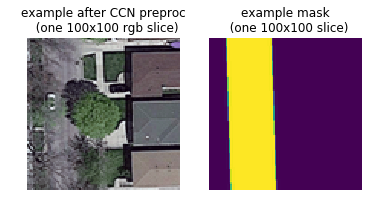

In [3]:
def preprocess_image_for_cnn(img):
    img = img.copy()
    d = img.shape[2]
    output_img = np.zeros([img.shape[0]*img.shape[1],d])
    for i in range(d):
        img[:,:,i] -= np.mean(img[:,:,i])
        img[:,:,i] /= np.linalg.norm(img[:,:,i])
        output_img[:,i] = img[:,:,i].reshape(img.shape[0]*img.shape[1]);
    
    return output_img

# returns 16 100x100 rgb images from one 400x400 rgb image
def slice_image_by_16_pieces(img):
    results = np.zeros([16, 100,100,3])
    for i in range(4):
        for j in range(4):
            results[j+4*i,:,:,:] = img[i*100:(i+1)*100,j*100:(j+1)*100,:]
        
    return results

# returns 16 100x100  images from one 400x400 image
def slice_mask_by_16_pieces(img):
    results = np.zeros([16, 100,100])
    for i in range(4):
        for j in range(4):
            results[j+4*i,:,:] = img[i*100:(i+1)*100,j*100:(j+1)*100]
        
    return results
        

# TRAIN DATA PREPARATION
# create 1600 baches of data 100x100 from 100 backes 400x400
train_data = np.zeros([1600,10000,3])
for i in range(n):
    temp = slice_image_by_16_pieces(imgs[i])
    for j in range(16):
        train_data[16*i + j,:,:] = preprocess_image_for_cnn(temp[j,:,:,:])
    

# TEST DATA PREPARATION
train_labels = np.zeros([1600,10000])
for i in range(n):
    temp = slice_mask_by_16_pieces(gt_imgs[i])
    for j in range(16):
        train_labels[16*i+j,:] = temp[j].reshape([10000]) -0.5 ## THE TRAIN LABELS SHOULD BE also -0.5 / +0.5

print('train labels shape= ', train_labels.shape)
print('train labels min= ', train_labels.min())
print('train labels max= ', train_labels.max())

print('train data shape= ', train_data.shape)
print('train data min= ', train_data.min())
print('train data max= ', train_data.max())

n = 1600 # nr of data 

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.subplot(121);
img_preprocessed = train_data[3].reshape([100,100,3])
img_preprocessed -= np.min(img_preprocessed);
img_preprocessed /= np.max(img_preprocessed);
plt.imshow(img_preprocessed);
plt.title('example after CCN preproc\n  (one 100x100 rgb slice)');
plt.axis('off')
plt.subplot(122);
plt.imshow(train_labels[3].reshape([100,100]));
plt.title('example mask\n  (one 100x100 slice)');
plt.axis('off');
plt.show()

# Model 1 
In the first model it has been implemented a baseline softmax classifier using a single convolutional layer and a one fully connected layer. For the initial baseline
it has not be used any regularization, dropout, or batch normalization.

The equation of the classifier is simply:


$$
y=\textrm{softmax}(ReLU( x_{400x400,3} \ast W_1+b_1)W_2+b_2) 
$$

For this first attempt have been applied 64 filters with size 10x10.  

In [4]:
def weight_variable2(shape, nc10):
        initial2 = tf.random_normal(shape, stddev=tf.sqrt(2./tf.to_float(ncl0)) )
        return tf.Variable(initial2)

def conv2d(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 1, 1, 1], padding='SAME')
    
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(shape, d):
        initial = tf.truncated_normal(shape, stddev=1/np.sqrt(d/2) )
        #initial = tf.constant(0.01,shape=shape)
        return tf.Variable(initial)
    
def bias_variable(shape):
    initial = tf.constant(0.01,shape=shape)
    return tf.Variable(initial)

In [14]:
# CNN for 3 colors - building computational graph

tf.reset_default_graph()

pix_w = 100      # image width in pix
d = pix_w*pix_w  # data dimensionality
nr_cols = 3      # number of colors 
batch_size = 20      # batch size

#Size and number of filters
K0 = 5   # size of the patch in the filter
F0 = 3  # number of filters
ncl0 = K0*K0*F0

# Inputs
xin_3cols = tf.placeholder(tf.float32,[batch_size,d, nr_cols]);  
y_truth = tf.placeholder(tf.float32,[batch_size,d]);

Wcl0 = weight_variable([nr_cols,K0,K0,1,F0], ncl0); print('Wcl=',Wcl0.get_shape())
bcl0 = bias_variable([nr_cols,F0]); print('bcl0=',bcl0.get_shape()) 

#Reshaping the input to size 400x400
x_2d0_r = tf.reshape(xin_3cols[:,:,0], [-1,pix_w,pix_w,1]); print('x_2d_r=',x_2d0_r.get_shape())
x_2d0_g = tf.reshape(xin_3cols[:,:,1], [-1,pix_w,pix_w,1]); print('x_2d_g=',x_2d0_g.get_shape())
x_2d0_b = tf.reshape(xin_3cols[:,:,2], [-1,pix_w,pix_w,1]); print('x_2d_b=',x_2d0_b.get_shape())
    
# Convolutional layer
x_r = tf.nn.conv2d(x_2d0_r, Wcl0[0], strides=[1, 1, 1, 1], padding='SAME')
x_r += bcl0[0]; print('x_r=',x_r.get_shape())

x_g = tf.nn.conv2d(x_2d0_g, Wcl0[1], strides=[1, 1, 1, 1], padding='SAME')
x_g += bcl0[1]; print('x_g=',x_g.get_shape())

x_b = tf.nn.conv2d(x_2d0_b, Wcl0[2], strides=[1, 1, 1, 1], padding='SAME')
x_b += bcl0[2]; print('x_b=',x_b.get_shape())
    
x = tf.pack([x_r, x_g, x_b])
print('x_final=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Fully Connected layer
nfc = pix_w*pix_w*F0*nr_cols
x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = weight_variable([nfc,d], pix_w); print('Wfc=',Wfc.get_shape()) 
bfc = bias_variable([d]); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

# Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())
print('y_truth',y_truth.get_shape())

total_loss = tf.reduce_mean(-tf.reduce_sum(y * y_truth)) # sometimes loss can be negative - dont know how to fix that

# Optimization scheme
train_step = tf.train.AdamOptimizer(0.0001).minimize(total_loss)

# Accuracy
accuracy = tf.reduce_mean(tf.reduce_sum(np.abs(y - y_truth)))/(batch_size*pix_w*pix_w)

Wcl= (3, 5, 5, 1, 3)
bcl0= (3, 3)
x_2d_r= (20, 100, 100, 1)
x_2d_g= (20, 100, 100, 1)
x_2d_b= (20, 100, 100, 1)
x_r= (20, 100, 100, 3)
x_g= (20, 100, 100, 3)
x_b= (20, 100, 100, 3)
x_final= (3, 20, 100, 100, 3)
x3= (20, 90000)
Wfc= (90000, 10000)
bfc= (10000,)
y1= (20, 10000)
y2= (20, 10000)
y3(SOFTMAX)= (20, 10000)
y_truth (20, 10000)


In [15]:
# Run Computational Graph
indices = collections.deque()
init = tf.global_variables_initializer()
sess = tf.Session()
print('Initializing computational Graph')
sess.run(init)
print('Finished computational Graph. Starting training.')
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x = train_data[idx,:]
    batch_y = train_labels[idx,:]
    
    # Run CG for vao to increase the test acriable training
    acc_train,total_loss_o = sess.run([accuracy,total_loss], feed_dict={xin_3cols: batch_x, y_truth: batch_y})
    
    # Run CG for test set
    if not i%10:
        print('\nIteration i=',i,', train accuracy=',np.sum(acc_train),', loss=',np.sum(total_loss_o))
 

Initializing computational Graph
Finished computational Graph. Starting training.

Iteration i= 0 , train accuracy= 0.486024 , loss= 7.22204

Iteration i= 10 , train accuracy= 0.479801 , loss= 6.00797

Iteration i= 20 , train accuracy= 0.480389 , loss= 6.06146

Iteration i= 30 , train accuracy= 0.481831 , loss= 6.20808


KeyboardInterrupt: 